In [42]:
# example of a wgan for generating handwritten digits
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras import backend
from tensorflow.keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint
from matplotlib import pyplot
import tensorflow as tf
import numpy as np
from keras.utils.vis_utils import plot_model


# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value

	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)

	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

# define the standalone critic model
def define_critic(in_shape=(28,28,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = ClipConstraint(0.01)
	# define model
	model = Sequential()
	# downsample to 14x14
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=in_shape))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 7x7
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# scoring, linear activation
	model.add(Flatten())
	model.add(Dense(1))
	# compile model
	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

# define the standalone generator model
def define_generator(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# output 28x28x1
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))
	return model

# define the combined generator and critic model, for updating the generator
def define_gan(generator, critic):
	# make weights in the critic not trainable
	for layer in critic.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the critic
	model.add(critic)
	# compile model
	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

# load images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# select all of the examples for a given class
	selected_ix = trainy == 7
	X = trainX[selected_ix]
	# expand to 3d, e.g. add channels
	X = expand_dims(X, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels, -1 for 'real'
	y = -ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels with 1.0 for 'fake'
	y = ones((n_samples, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(10 * 10):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'seeded_generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'seeded_model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
	# plot history
	pyplot.plot(d1_hist, label='crit_real')
	pyplot.plot(d2_hist, label='crit_fake')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
	pyplot.savefig('seeded_plot_line_plot_loss.png')
	pyplot.close()

# train the generator and critic
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64, n_critic=5):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# lists for keeping track of loss
	c1_hist, c2_hist, g_hist = list(), list(), list()
	# manually enumerate epochs
	for i in range(n_steps):
		# update the critic more than the generator
		c1_tmp, c2_tmp = list(), list()
		for _ in range(n_critic):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update critic model weights
			c_loss1 = c_model.train_on_batch(X_real, y_real)
			c1_tmp.append(c_loss1)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update critic model weights
			c_loss2 = c_model.train_on_batch(X_fake, y_fake)
			c2_tmp.append(c_loss2)
		# store critic loss
		c1_hist.append(mean(c1_tmp))
		c2_hist.append(mean(c2_tmp))
		# prepare points in latent space as input for the generator
		X_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = -ones((n_batch, 1))
		# update the generator via the critic's error
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		g_hist.append(g_loss)
		# summarize loss on this batch
		print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
		# evaluate the model performance every 'epoch'
		if (i+1) % bat_per_epo == 0:
			summarize_performance(i, g_model, latent_dim)
	# line plots of loss
	plot_history(c1_hist, c2_hist, g_hist)

    
np.random.seed(1234)
tf.random.set_seed(1234)
# size of the latent space
latent_dim = 50
# create the critic
critic = define_critic()
plot_model(critic, to_file='WGAN_critic_plot.png', show_shapes=True, show_layer_names=True)
# create the generator
generator = define_generator(latent_dim)
plot_model(generator, to_file='WGAN_generator_plot.png', show_shapes=True, show_layer_names=True)
# create the gan
gan_model = define_gan(generator, critic)
plot_model(gan_model, to_file='WGAN_GAN_plot.png', show_shapes=True, show_layer_names=True)
# load image data
dataset = load_real_samples()
print(dataset.shape)
# train model
train(generator, critic, gan_model, dataset, latent_dim)

2022-02-20 12:00:32.847802: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-20 12:00:32.847910: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/wuw/miniforge3/envs/env_tendorflow/lib/python3.9/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Metal device set to: Apple M1 Pro


/Users/wuw/miniforge3/envs/env_tendorflow/lib/python3.9/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


(6265, 28, 28, 1)


2022-02-20 12:00:34.695751: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-20 12:00:34.696523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-20 12:00:35.675666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-20 12:00:36.278452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


>1, c1=-2.712, c2=0.039 g=-0.666
>2, c1=-7.167, c2=0.125 g=-2.146
>3, c1=-10.179, c2=0.192 g=-2.909
>4, c1=-12.373, c2=0.241 g=-4.026
>5, c1=-14.510, c2=0.303 g=-4.898
>6, c1=-16.474, c2=0.348 g=-5.680
>7, c1=-18.039, c2=0.390 g=-6.297
>8, c1=-19.218, c2=0.434 g=-7.402
>9, c1=-20.526, c2=0.495 g=-8.470
>10, c1=-21.521, c2=0.572 g=-9.522
>11, c1=-22.270, c2=0.652 g=-10.645
>12, c1=-23.335, c2=0.732 g=-11.844
>13, c1=-24.235, c2=0.833 g=-12.706


KeyboardInterrupt: 

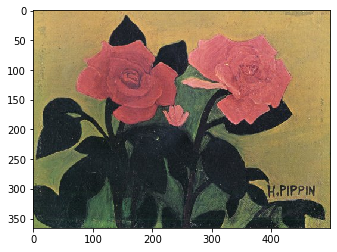

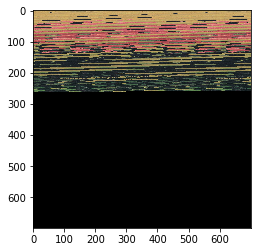

In [13]:
import matplotlib.pyplot as plt
from PIL import Image
import scipy.misc
import numpy as np
name = "1da82900ca117319d6aa91852bbfe002c.jpg"
def load_image(filename):
    img = np.asarray(Image.open(filename))
    img = img.astype("float32") / 255.
    return img
def gray2rgb(image):
    return np.repeat(np.expand_dims(image, 2), 3, axis=2)
def show_image(img):
    plt.figure()
    if len(img.shape) == 2:
        img = gray2rgb(img)
    plt.imshow(img, interpolation='nearest')
    
# load the image
im = load_image(name)
#im = im.mean(axis=2) # convert to grayscale
show_image(im)
im.shape

new_image = im.resize((700, 700, 3))
show_image(im)

#image = scipy.misc.imresize(image,(64,64))
#show_image(image)

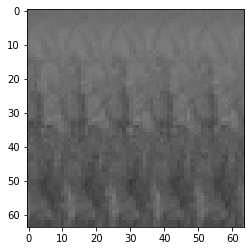

In [30]:
image = im.mean(axis=2)
cropped = np.array(Image.fromarray(image).resize(size=(64, 64)))
show_image(cropped)

Original Dimensions :  (366, 500, 3)
Resized Dimensions :  (128, 128, 3)


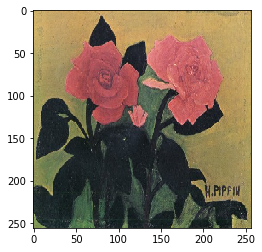

In [31]:
import cv2
def resize_image(img, dim):
    # resize image
    image = cv2.resize(img, dim, interpolation = cv2.INTER_NEAREST)
    return image
 
img = load_image(name)
 
print('Original Dimensions : ',img.shape)
 
dim = (256, 256)
  
# resize image
image = resize_image(img, dim)
 
print('Resized Dimensions : ',resized.shape)
 
cv2.imshow("Resized image", image)
show_image(image)

In [45]:
from keras.datasets.mnist import load_data
from numpy import expand_dims

# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # select all of the examples for a given class
    selected_ix = trainy == 7
    X = trainX[selected_ix]
    # expand to 3d, e.g. add channels
    X = expand_dims(X, axis=-1)
    print(X.shape)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X
data = load_real_samples()

(6265, 28, 28, 1)
